In [1]:
%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt
import math
from matplotlib.patches import Ellipse
from torch import nn
import torch
from torch import optim
import torch.nn.functional as F

In [2]:
def predict(model, x):
    return model(x-0.5)

def print_predictions(model):
    print(', '.join('%.3f' % v for v in predict(model, x)))

def plot_model(ax, model):
    val_x = np.linspace(0, 1, 1000)
    val_y = np.linspace(0, 1, 1000)
    val_x, val_y = np.meshgrid(val_x, val_y)
    input = np.stack([val_x.flatten(), val_y.flatten()], axis=-1)
    preds = predict(model, torch.from_numpy(input).float()).detach()
    val_z = preds.reshape(val_x.shape)
    ax.contourf(val_x, val_y, val_z, levels=[0, 0.49999, 1], colors=['white', 'silver'], origin='lower')
    
# plot_model(plt, relu)

# Dataset

In [3]:
xa = np.random.multivariate_normal([0.18, 0.85], np.diag([0.003, 0.002]), size=20).clip(0, 1)
xb = np.random.multivariate_normal([0.85, 0.9], [[0.002, -0.001], [-0.001, 0.0025]], size=20).clip(0, 1)
xc = np.random.multivariate_normal([0.5, 0.2], np.diag([0.02, 0.01]), size=40).clip(0, 1)

In [4]:
x = torch.tensor(np.concatenate([xa, xb, xc])).float()
y = torch.tensor(np.concatenate([np.ones(len(xa)), np.ones(len(xb)), np.zeros(len(xc))])).long()

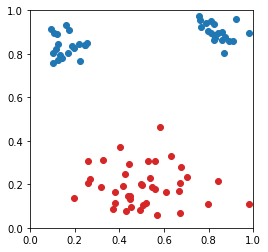

In [5]:
def plot_data(ax):
    positive_dots = x[y==1]
    negative_dots = x[y==0]
    ax.scatter(positive_dots[:,0], positive_dots[:,1], color='tab:blue')
    ax.scatter(negative_dots[:,0], negative_dots[:,1], color='tab:red')
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    
fig, ax = plt.subplots(figsize=(4, 4))
plot_data(ax)

# ReLU

In [6]:
def train_and_plot(model, regularization_func=None, regularization_strengths={}, n_epochs=100, lr=0.5):
    loss_func = nn.MSELoss() # tried NLLLoss, fitting is still difficult
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        preds = predict(model, x)
        main_loss = loss_func(preds, y.float())
        reg_loss = 0
        if regularization_func is not None:
            if epoch == n_epochs // 2:
                print('Before regularization')
                fig, ax = plt.subplots(figsize=(4, 4))
                plot_model(ax, model)
                plt.show()
            if epoch >= n_epochs//2:
                regs = regularization_func(model)
                reg_loss = sum((regularization_strengths[k]*regs[k] for k in regs), 0)
        loss = main_loss + reg_loss
        loss.backward()
        optimizer.step()
    
    acc = ((preds >= 0.5) == (y ==1)).float().mean().item()
    print('Accuracy: %.2f' % acc)
        
    fig, ax = plt.subplots(figsize=(4, 4))
    plot_model(ax, model)
    plot_data(ax)

Parameter containing:
tensor([[-0.4547, -0.6941]], requires_grad=True)
Accuracy: 0.50


/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


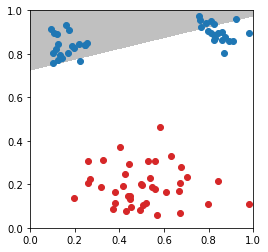

In [7]:
relu = nn.Sequential(
    nn.Linear(2, 1),
    nn.ReLU(),
)
print(relu[0].weight)
train_and_plot(relu)

In [8]:
print_predictions(relu)

0.500, 0.501, 0.500, 0.500, 0.500, 0.500, 0.501, 0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.501, 0.501, 0.500, 0.500, 0.501, 0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.499, 0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.496, 0.497, 0.496, 0.497, 0.496, 0.497, 0.498, 0.498, 0.496, 0.497, 0.496, 0.497, 0.497, 0.497, 0.497, 0.496, 0.497, 0.497, 0.498, 0.497, 0.496, 0.497, 0.497, 0.496, 0.497, 0.497, 0.496, 0.497, 0.498, 0.496, 0.496, 0.496, 0.497, 0.497, 0.497, 0.497, 0.497, 0.497, 0.496, 0.497


In [9]:
relu[0].weight

Parameter containing:
tensor([[-0.0012,  0.0049]], requires_grad=True)

# Min-max-out

In [10]:
class Minmaxout(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_min = 2
        self.num_max = 2
        self.linear = nn.Linear(2, self.num_min * self.num_max)

    def forward(self, input):
        z = self.linear(input)
        z, _ = z.reshape(input.shape[0], self.num_max, self.num_min, -1).min(axis=2, keepdim=False)
        z, _ = z.max(axis=1, keepdim=False)
        return F.relu(z)
    
def regularize_mm(mm_model):
    w = mm_model.linear.weight
    w_l2 = w.pow(2).sum()
    bias_reg = mm_model.linear.bias.sum()
    return {'l2': w_l2, 'bias_l1': bias_reg}

Before regularization


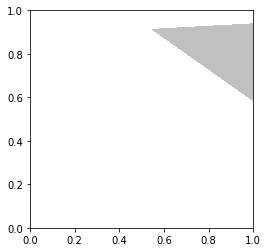

Accuracy: 0.50


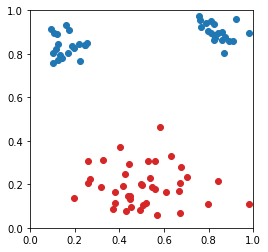

In [11]:
minmaxout = Minmaxout()
train_and_plot(minmaxout, regularize_mm, regularization_strengths={'l2': 0.001, 'bias_l1': 0.05})

In [12]:
print_predictions(minmaxout)

0.451, 0.452, 0.450, 0.455, 0.456, 0.452, 0.455, 0.455, 0.449, 0.453, 0.450, 0.456, 0.449, 0.448, 0.453, 0.452, 0.452, 0.450, 0.453, 0.455, 0.479, 0.478, 0.480, 0.480, 0.478, 0.479, 0.479, 0.479, 0.478, 0.480, 0.478, 0.480, 0.480, 0.484, 0.478, 0.485, 0.481, 0.477, 0.478, 0.479, 0.453, 0.439, 0.451, 0.444, 0.450, 0.435, 0.449, 0.441, 0.456, 0.452, 0.446, 0.447, 0.441, 0.446, 0.448, 0.443, 0.454, 0.444, 0.458, 0.447, 0.444, 0.456, 0.456, 0.440, 0.444, 0.449, 0.461, 0.440, 0.444, 0.445, 0.442, 0.463, 0.444, 0.440, 0.453, 0.449, 0.442, 0.450, 0.446, 0.456


# Elliptical

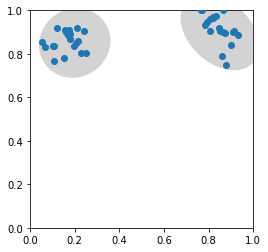

In [38]:
def plot_two_clouds_eliptic(ax):
    ellipse1 = Ellipse(xy=(0.2, 0.85), width=0.33, height=0.31, angle=45)
    ellipse1.set_zorder(1)
    ellipse1.set_facecolor('lightgray')
    ellipse2 = Ellipse(xy=(0.85, 0.9), width=0.28, height=0.41, angle=45)
    ellipse2.set_zorder(1)
    ellipse2.set_facecolor('lightgray')
    
    ax.add_patch(ellipse1)
    ax.add_patch(ellipse2)
    ax.scatter(xa[:,0], xa[:,1], color='tab:blue', zorder=3)
    ax.scatter(xb[:,0], xb[:,1], color='tab:blue', zorder=4)
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    
fig, ax = plt.subplots(figsize=(4, 4))
plot_two_clouds_eliptic(ax)